In [1]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi


In [2]:
get_ipython().system_raw('./ngrok http 6006 &')

In [3]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Tensorboard Link: https://8091f96ee40b.ngrok.io


In [4]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
import tensorflow as tf
import numpy as np
import scipy.misc 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x


class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        
        self.writer = tf.summary.create_file_writer('log_dir')
        # if the above does not work use
        
        #self.writer = tf.summary.FileWriter(log_dir)
        
        

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        #summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        #self.writer.add_summary(summary, step)
        # if the above does not work use

        with self.writer.as_default():
    
              tf.summary.scalar(tag, value, step=step)

              self.writer.flush()
    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()

  

In [5]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt

logger = Logger('./logs')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     

### (a) Plot the training and validation losses and errors as a function of the number of epochs


 The model currently does not achieve less than 12% validation error, you have to tweak the parameters to get it.

In [6]:
# Reading in the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
# The training loop

def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    for epoch in range(epochs):
        correct = 0
        total = 0
        flag = 0
        running_loss = 0.0
        if epoch == 25 and flag == 0:
          for op_params in optimizer.param_groups:
            op_params['lr'] = 0.001
          flag = 1
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            if (i+1) % 1000 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item() }

              for tag, value in info.items():
                logger.scalar_summary(tag, value, overall_step+1)
        train_loss_values.append(running_loss)
        train_error.append(100-100*correct/total)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        val_error.append(100-100*correct/total)
        val_loss_values.append(running_loss)
    return val_error,val_loss_values,train_error,train_loss_values


In [9]:
model = allcnn_t().to(device)
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00001, nesterov=True)
val_error,val_loss_values,train_error,train_loss_values= train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn_curve', True)

Num parameters:  1667166
Epoch [1/50], Step [1000/3125], Loss: 1.4021
Epoch [1/50], Step [2000/3125], Loss: 1.4570
Epoch [1/50], Step [3000/3125], Loss: 1.2364
Accuracy of the network on the test images: 52.76 %
Epoch [2/50], Step [1000/3125], Loss: 0.9655
Epoch [2/50], Step [2000/3125], Loss: 0.6592
Epoch [2/50], Step [3000/3125], Loss: 0.8278
Accuracy of the network on the test images: 69.9 %
Epoch [3/50], Step [1000/3125], Loss: 0.7825
Epoch [3/50], Step [2000/3125], Loss: 0.8221
Epoch [3/50], Step [3000/3125], Loss: 0.7570
Accuracy of the network on the test images: 78.13 %
Epoch [4/50], Step [1000/3125], Loss: 0.3162
Epoch [4/50], Step [2000/3125], Loss: 0.2642
Epoch [4/50], Step [3000/3125], Loss: 0.3125
Accuracy of the network on the test images: 79.35 %
Epoch [5/50], Step [1000/3125], Loss: 0.3841
Epoch [5/50], Step [2000/3125], Loss: 0.2606
Epoch [5/50], Step [3000/3125], Loss: 0.3401
Accuracy of the network on the test images: 80.52 %
Epoch [6/50], Step [1000/3125], Loss: 0.4

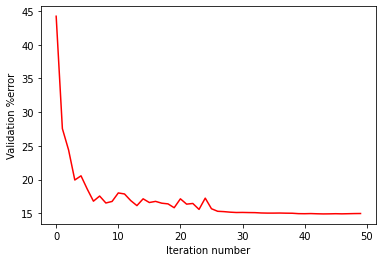

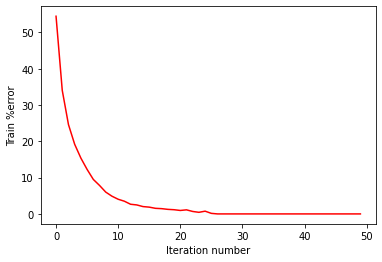

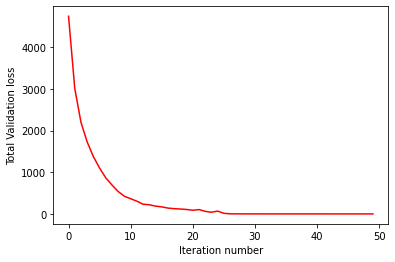

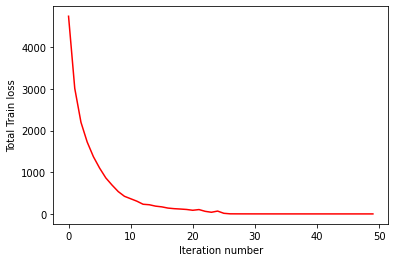

In [ ]:
plt.plot(val_error, 'r')
plt.xlabel('Iteration number')
plt.ylabel('Validation %error')
plt.show()

plt.plot(train_error, 'r')
plt.xlabel('Iteration number')
plt.ylabel('Train %error')
plt.show()

plt.plot(val_loss_values, 'r')
plt.xlabel('Iteration number')
plt.ylabel('Total Validation loss')
plt.show()

plt.plot(train_loss_values, 'r')
plt.xlabel('Iteration number')
plt.ylabel('Total Train loss')
plt.show()

### (b) Plot the gradients for the images which were corrctly classified and misclassified

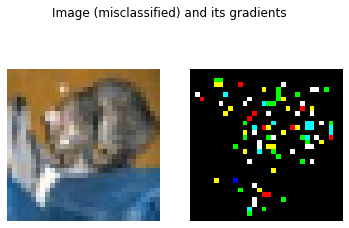

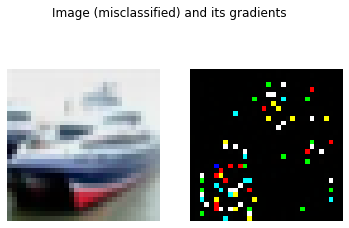

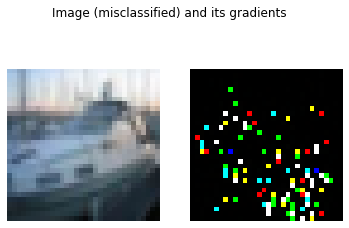

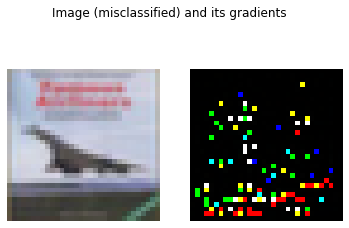

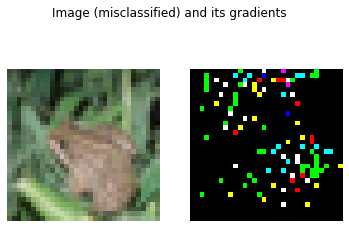

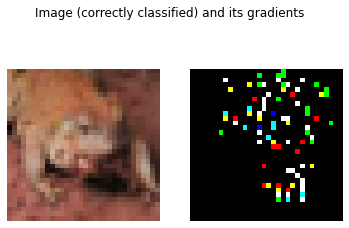

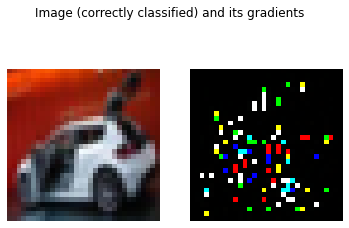

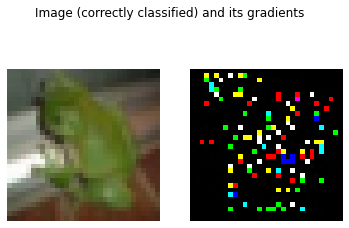

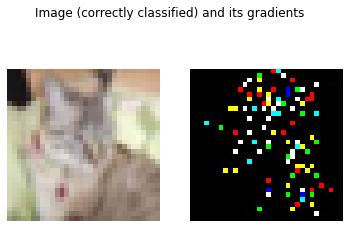

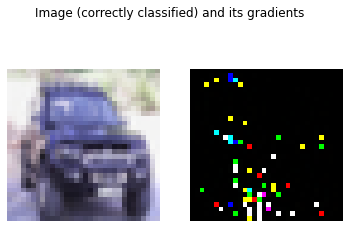

In [25]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False)
model.eval()
correct = 0
misclass = 0
for i, (images, labels) in enumerate(testloader):
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True

    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()

    _, predicted = torch.max(outputs.data, 1)
    if correct == 5:
        break

    if ((predicted != labels).sum().item() == 0) and (misclass < 5):
        dx = images.grad.data.clone()
        grad = dx.to('cpu')
        grad_n = (grad.detach().numpy())[0]
        grad_n = grad_n.transpose((1,2,0))
        grad_n = (grad_n - np.mean(grad_n))/ np.std(grad_n) + 0.5

        fig, axs = plt.subplots(1, 2)
        fig.suptitle('Image (misclassified) and its gradients')
        axs[0].imshow(testloader.dataset.data[i].astype('uint8'))
        axs[0].axis('off')
        axs[1].imshow(grad_n.astype('uint8'))
        axs[1].axis('off')
        misclass += 1
    else:
        dx = images.grad.data.clone()
        grad = dx.to('cpu')
        grad_n = (grad.detach().numpy())[0]
        grad_n = grad_n.transpose((1,2,0))
        grad_n = (grad_n - np.mean(grad_n))/ np.std(grad_n) + 0.5

        fig, axs = plt.subplots(1, 2)
        fig.suptitle('Image (correctly classified) and its gradients')
        axs[0].imshow(testloader.dataset.data[i].astype('uint8'))
        axs[0].axis('off')
        axs[1].imshow(grad_n.astype('uint8'))
        axs[1].axis('off')
        correct += 1

### Plot the loss on the perturbed images as a function of the number of steps in the attack averaged across mini-batch

Step: 0 Loss: 75.05520665831247
Step: 1 Loss: 1679.3379196696433
Step: 2 Loss: 4588.735072612762
Step: 3 Loss: 6964.415126800537
Step: 4 Loss: 8921.301216125488


Text(0, 0.5, 'Loss')

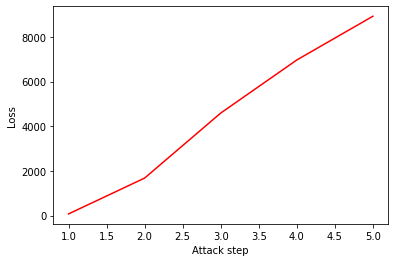

In [27]:
# Randomly selecting 100 samples
from torch.utils.data import SubsetRandomSampler
sampler = SubsetRandomSampler(list(range(100)))
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False,
                                         sampler=sampler)

eps = 8.0
images = []
labels = []
for i, (image, label) in enumerate(testloader):
    images.append(image)
    labels.append(label)

losses = []
for k in range(5):
  l = 0
  for i in range(100):
    image = images[i].to(device) 
    label = labels[i].to(device)
    image = nn.Parameter(image)
    image.requires_grad = True   
    output = model(image)
    loss = criterion(output, label)
    optimizer.zero_grad()
    loss.backward()
    l += loss.item()
    dx = image.grad.data.clone()
    dx = torch.sign(dx)
    images[i] = image + (eps/255)*dx
  losses.append(l)
  print("Step: {} Loss: {}".format(k,l))

plt.plot(np.arange(5)+1, losses, 'r')
plt.xlabel('Attack step')
plt.ylabel('Loss')

### (c) Compute the accuracy of the network on 1-step perturbed images

In [29]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False)

eps = 8.0
images = []
labels = []
for i, (image, label) in enumerate(testloader):
    images.append(image)
    labels.append(label)

# Check the accuracy on the sample before the attack
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for i in range(len(images)):
      image = images[i].to(device) 
      label = labels[i].to(device)
      output = model(image)
      _, predicted = torch.max(output.data, 1)
      total += label.size(0)
      correct += (predicted == label).sum().item()

print("Accuracy on the sample before the attack: {}%".format(100*correct/total))

for i in range(len(images)):
    image = images[i].to(device) 
    label = labels[i].to(device)
    image = nn.Parameter(image)
    image.requires_grad = True   
    output = model(image)
    loss = criterion(output, label)
    optimizer.zero_grad()
    loss.backward()
    dx = image.grad.data.clone()
    dx = torch.sign(dx)
    images[i] = image + (eps/255)*dx

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for i in range(len(images)):
      image = images[i].to(device) 
      label = labels[i].to(device)
      output = model(image)
      _, predicted = torch.max(output.data, 1)
      total += label.size(0)
      correct += (predicted == label).sum().item()

print("Accuracy on the sample after the attack: {}%".format(100*correct/total))

Accuracy on the sample before the attack: 85.75%
Accuracy on the sample after the attack: 25.01%
